In [ ]:
# Run this cell, if you are running the notebook on Google Colab:
!git clone https://github.com/CRC183-summer-school/school_2021.git

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(sys.path[0] + "./school_2021/notebooks/")
from IsingData import generate_Ising_configurations

# Zipping the Ising model

<h2 style="color:red"> !! The cell below takes a couple of minutes to run locally on a MacBook Pro </h2>

Try decreasing the number of samples from 1000 -> 100 to get a quick idea

In [4]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.6, 3.0, 0.1) #np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = {}
for L in [10, 20, 40]:#, 80]:
    all_data[L] = generate_Ising_configurations(L, 1000, Ts)

Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.700
Generating samples for L = 10 at T = 1.800
Generating samples for L = 10 at T = 1.900
Generating samples for L = 10 at T = 2.000
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.200
Generating samples for L = 10 at T = 2.300
Generating samples for L = 10 at T = 2.400
Generating samples for L = 10 at T = 2.500
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.700
Generating samples for L = 10 at T = 2.800
Generating samples for L = 10 at T = 2.900
Generating samples for L = 20 at T = 1.600
Generating samples for L = 20 at T = 1.700
Generating samples for L = 20 at T = 1.800
Generating samples for L = 20 at T = 1.900
Generating samples for L = 20 at T = 2.000
Generating samples for L = 20 at T = 2.100
Generating samples for L = 20 at T = 2.200
Generating samples for L = 20 at T = 2.300
Generating samples for L = 20 at T = 2.400
Generating 

In [5]:
import gzip
import shutil

sizes = {}
Ts = np.arange(1.6, 3.0, 0.1)
for L in [10, 20, 40]:#, 80]:
    sizes[L] = []

    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        out = gzip.compress(data)
        sizes[L].append(out.__sizeof__())

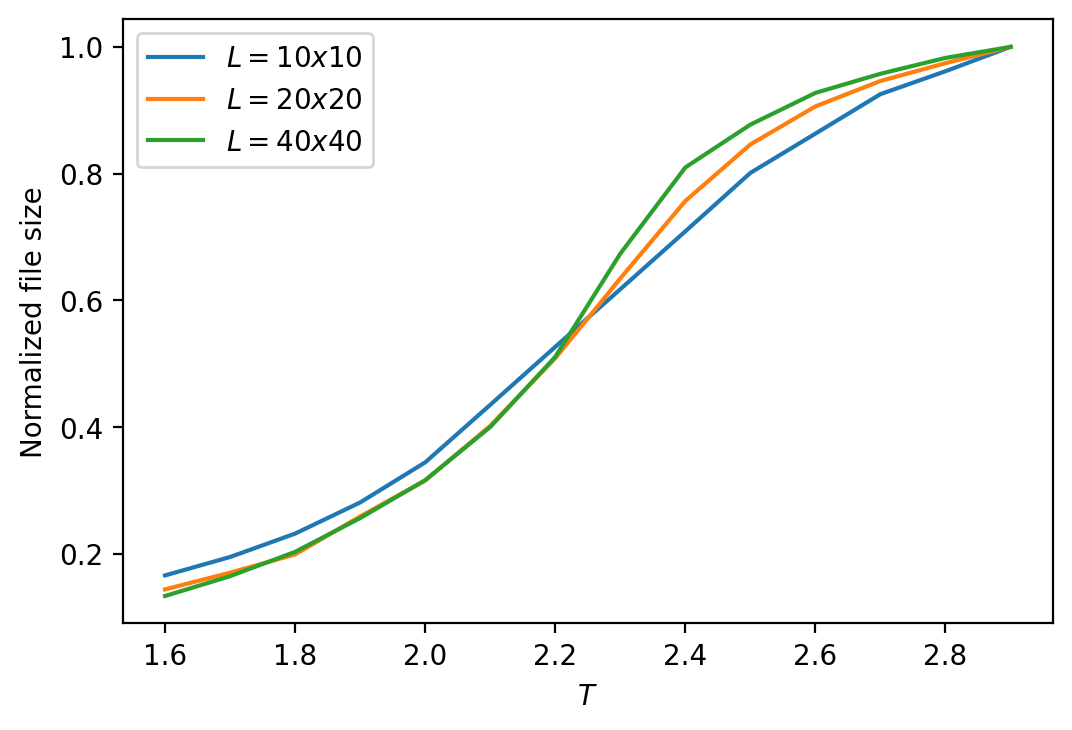

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)
for L in [10, 20, 40]:#, 80]:
    ax.plot(Ts, sizes[L]/np.max(sizes[L]), label='$L=%dx%d$'%(L,L))
    
ax.set_xlabel("$T$")
ax.set_ylabel("Normalized file size")
ax.legend(fancybox=True)

## Challenge idea

Add system size 80, more samples, and try a scaling collapse to extract T_c

# PCA'ing the Ising model

Be sure to also check out https://arxiv.org/abs/1606.00318

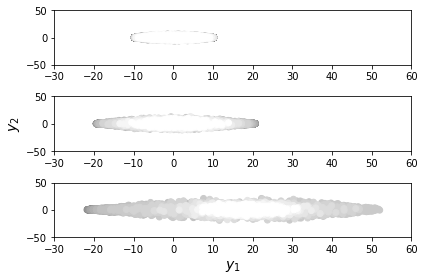

In [41]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(3,1)
Ts = np.arange(1.6, 3.0, 0.1)
principal_vectors = [] 
for a,L in enumerate([10,20,40]):
    raw_x = []
    colors = [] 
   
    for t,T in enumerate(Ts):
        
        data = all_data[L]['%.3f'%T]
        
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 

    pca = PCA(n_components=2)
    pca.fit(raw_x)
    proj = pca.transform(raw_x)
    principal_vectors.append( pca.components_[0] )
    ax[a].scatter(proj[:,0], proj[:,1], color=colors)
    
    ax[a].set_xlim([-30,60])
    ax[a].set_ylim([-50,50])
    
ax[1].set_ylabel("$y_2$", fontsize=14)
ax[2].set_xlabel("$y_1$", fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'First principal component vector')

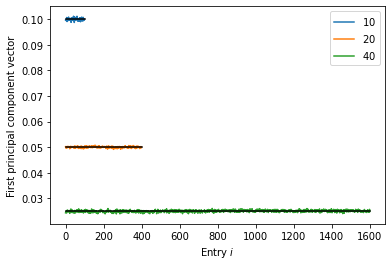

In [42]:
fig, ax = plt.subplots()

for a,L in enumerate([10,20,40]):
    ax.plot(np.abs(principal_vectors[a]), label="$%d$"%L)
    ax.plot([0, L**2], [1/L, 1/L], c='k')
    
ax.legend(fancybox=True)
ax.set_xlabel("Entry $i$")
ax.set_ylabel("First principal component vector")

We see here that the dominant principal component is quite a uniform vector. Think about what this means for when we project a sample $x$ to the latent space. If the principal component vector $P$ is uniform with value $1/L$, then $P\cdot x$ is just the (sum of x)/L. And the sum of x is the total magnetization, which we know can act as an order parameter!

# VAE'ing the Ising model

In [ ]:
train_x = [a]

In [35]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500, name='fc1')(x)
        x = nn.relu(x)
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(500, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(10**2, name='fc2')(z)  # L = 10
        return z

In [36]:
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [37]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [43]:
batch_size = 32
init_data = jnp.ones((batch_size, 100), jnp.float32)

key = random.PRNGKey(0)

latent_dim = 4
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-2).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(train_x) // batch_size

num_epochs = 10
for epoch in range(num_epochs):
    # Shuffle data
    indices = np.random.permutation(len(train_x))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = train_x[batch_indices[b]]
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)

NameError: name 'train_x' is not defined

# Bonus: '2NN'-ing the Ising model

In [19]:
def compute_distance(d1, d2):
    return np.count_nonzero(d1*d2+1)/(2*len(d1))
    
def nn2(data):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    
    # Making the distance matrix
    for i,d1 in enumerate(data):
        for j,d2 in enumerate(data):
            if j <= i: # We don't need this because the matrix is symmetric
                continue
            else:
                distance = compute_distance(d1, d2)
                distance_matrix[i,j], distance_matrix[j,i] = distance, distance
                
    # Table of distances - state and \mu= r_2/r_1
    mu = np.zeros((N,2))
    for index, line in enumerate(distance_matrix):
        r1, r2 = sorted(line)[1:3]        
        mu[index,0] = index+1     
        mu[index,1] = 0.1
        if( r1 != 0 ):
            mu[index,1] = r2/r1
        
    # Permutation function
    sigma_i = dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))
    mu = dict(mu)
    F_i = {}
    for i in mu:
        F_i[sigma_i[i]] = i/N

    #fitting coordinates
    x = np.log([mu[i] for i in sorted(mu.keys())])
    y = np.array([1-F_i[i] for i in sorted(mu.keys())])

    #avoid having log(0)
    x = x[y>0]
    y = y[y>0]
    y = -1*np.log(y)

    # fit line through origin to get the dimension
    m = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]
    return m, x, y

In [20]:
IDs = {}
for num_snaps in [100, 250, 500, 1000]:
    print("Num snaps: %d"%num_snaps)
    IDs[num_snaps] = []
    
    for T in Ts:
        print("\t Computing the intrinsic dimension for T = %.2f"%T)
        data =  data = all_data[10]['%.3f'%T]
        snapshots = data[:num_snaps]
        m, _, _ = nn2(snapshots)
        IDs[num_snaps].append(m)

Num snaps: 100
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for T = 2.10
	 Computing the intrinsic dimension for T = 2.20
	 Computing the intrinsic dimension for T = 2.30
	 Computing the intrinsic dimension for T = 2.40
	 Computing the intrinsic dimension for T = 2.50
	 Computing the intrinsic dimension for T = 2.60
	 Computing the intrinsic dimension for T = 2.70
	 Computing the intrinsic dimension for T = 2.80
	 Computing the intrinsic dimension for T = 2.90
Num snaps: 250
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for

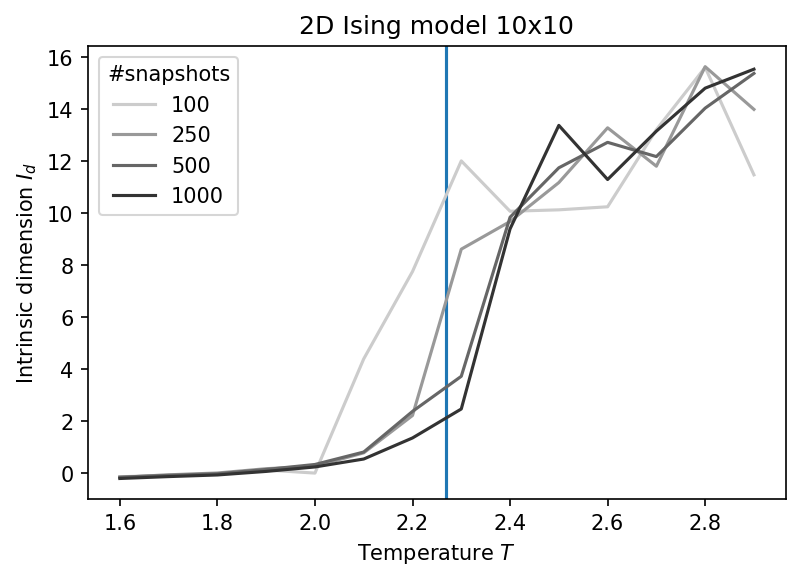

In [21]:
fig, ax = plt.subplots(dpi=150)

Tc = 2/np.log(1+np.sqrt(2))
ax.axvline(x=Tc)

colors = [(0.8, 0.8, 0.8), (0.6, 0.6, 0.6), (0.4, 0.4, 0.4), (0.2, 0.2, 0.2)]
for i,num_snaps in enumerate([100, 250, 500, 1000]):
    ax.plot(Ts, IDs[num_snaps], label="%d"%num_snaps, color=colors[i])
    
ax.set_xlabel("Temperature $T$")
ax.set_ylabel("Intrinsic dimension $I_d$")
ax.set_title("2D Ising model %dx%d"%(10,10))
ax.legend(fancybox=True, title="#snapshots")